In [1]:
import scanpy as sc
import scanpy.external as sce

import anndata
from pathlib import Path
from tqdm import tqdm
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from upsetplot import UpSet
from upsetplot import from_contents

In [3]:
#import relation_data_lake as rdl

In [4]:
from scipy import stats

In [5]:
import scipy.sparse as sp
import anndata as ad

In [6]:
import json

import dask.dataframe as dd
import numpy as np
import pandas as pd
#import relation_data_lake as rdl
import scanpy as sc
import scipy.sparse as sp
from anndata import AnnData
#from relation_data_lake.aws.aws_api import pull_folder

In [7]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=400, figsize = [1.5*6.4, 1.5*4.8])

In [8]:
n_jobs = 50

sc._settings.ScanpyConfig(
    n_jobs=n_jobs
)

***
# Background functions

In [9]:
def create_plots(adata, color_key_obs):
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color = color_key_obs)
    
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = color_key_obs)  
    
    sns.histplot(adata.obs, x = 'total_counts', hue = color_key_obs, 
                 common_norm = False, stat = 'probability', alpha = 0.5, element="poly",fill = False)
    plt.show()
    plt.clf()
    
    
    sns.histplot(adata.obs, x = 'n_genes_by_counts', hue = color_key_obs, 
                 common_norm = False, stat = 'probability', alpha = 0.5, element="poly",fill = False)
    plt.show()
    plt.clf()
    
    sns.histplot(adata.obs, x = 'pct_counts_mt', hue = color_key_obs, 
                 common_norm = False, stat = 'probability', alpha = 0.5, element="poly",fill = False)
    plt.show()
    plt.clf()
    
    sc.pl.highest_expr_genes(adata, n_top=20)
    
    #sns.histplot(adata.var, x = 'pct_dropout_by_counts', 
    #             common_norm = False, stat = 'probability', alpha = 0.5, element="poly",fill = False)
    #plt.show()
    #plt.clf()
    
def create_plots_and_save(adata, color_key_obs, file_name):
    ## Total counts vs. pct counts mito
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color = color_key_obs, save="_"+file_name+"_total_counts_pct_mounts_mt.png")
    
    ## Total counts vs. number genes by counts.
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = color_key_obs, save="_"+file_name+"_total_counts_n_genes_by_counts.png")  
    
    ## Total counts hist.
    sns.histplot(adata.obs, x = 'total_counts', hue = color_key_obs, 
                 common_norm = False, stat = 'probability', alpha = 0.5, element="poly",fill = False)
    plt.savefig("figures/"+file_name+"_total_counts.png", dpi=400)
    plt.show()
    plt.clf()
    
    ## Number of genes for each cell.
    sns.histplot(adata.obs, x = 'n_genes_by_counts', hue = color_key_obs, 
                 common_norm = False, stat = 'probability', alpha = 0.5, element="poly",fill = False)
    plt.savefig("figures/"+file_name+"_n_genes_by_counts.png", dpi=400)
    plt.show()
    plt.clf()
    
    ## Percent mitochrondria
    sns.histplot(adata.obs, x = 'pct_counts_mt', hue = color_key_obs, 
                 common_norm = False, stat = 'probability', alpha = 0.5, element="poly",fill = False)
    plt.savefig("figures/"+file_name+"_pct_counts_mt.png", dpi=400)
    plt.show()
    plt.clf()
    
def remove_non_significant(adata, retain_list, pv_threshold):
    control_samp = adata[adata.obs.target == 'non-targeting'].obs.dpt_pseudotime 
    target_list = adata.obs.target.unique()
    for ii in target_list:
        if not (ii in retain_list):
            test_samp = adata[adata.obs.target == ii].obs.dpt_pseudotime 
            xx = stats.ks_2samp(control_samp, test_samp)
            print([ii, xx.pvalue])
            if xx.pvalue > pv_threshold:
                adata = adata[adata.obs.target !=  ii]
    return adata

def get_DE_pert_genes(adata, reference_cat):
    sc.tl.rank_genes_groups(adata, "target", reference=reference_cat,rankby_abs=True, pts = True)  
    yy = sc.get.rank_genes_groups_df(adata, group = None)
    yy.names = yy.names.astype("category")
    ind_pos =  (yy.logfoldchanges > 1) & (yy.pvals < 0.01)
    ind_neg =  (yy.logfoldchanges < -1) & (yy.pvals < 0.01)
    ind_total = ind_pos | ind_neg
    yy = yy[ind_total]
    s_genes = yy.names.unique()
    #print(len(s_genes))
    return s_genes
    


***
# Load data and create objects

In [10]:
adata_Rd1 = sc.read_h5ad('../Rd1_Data_post_sgRNA_rescue-reseq.h5ad.gzip')

In [11]:
adata_Rd3 = sc.read_h5ad('../Rd3_Data_post_sgRNA_rescue-reseq.h5ad.gzip')


In [12]:
adata = ad.concat({'Rd1': adata_Rd1, 'Rd3': adata_Rd3}, axis = 0)

In [13]:
adata.obs

sgRNA  \
cell_id                                                                      
AAACCCAAGAATCGTA-1-Activated_OP1L_NM_NA_Rep1_La...  Kat5_Br_45092|NTC_0005   
AAACCCAAGATAACGT-1-Activated_OP1L_NM_NA_Rep1_La...           Kat8_As_45860   
AAACCCAAGATCCCAT-1-Activated_OP1L_NM_NA_Rep1_La...                NTC_0005   
AAACCCAGTCTCTCCA-1-Activated_OP1L_NM_NA_Rep1_La...           Znhit1_As_222   
AAACGAAAGGGTAATT-1-Activated_OP1L_NM_NA_Rep1_La...                NTC_0005   
...                                                                    ...   
TTTCAGTAGGGCGAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...         Setd1b_Br_52333   
TTTCATGTCCGATCTC-1-exVivo_OP2_TGFb_2_LaraMouseF...           Chd4_As_66308   
TTTGACTAGGGATCAC-1-exVivo_OP2_TGFb_2_LaraMouseF...                  EGR2_3   
TTTGGTTGTAGGAAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...          Pbrm1_As_28642   
TTTGTTGCATGCAGGA-1-exVivo_OP2_TGFb_2_LaraMouseF...          Kmt2a_Br_53969   

                                                    misc:umi_count condition  \
cell_id                                                                        
AAACCCAAGAATCGTA-1-Activated_OP1L_NM_NA_Rep1_La...         33999.0     Tgfb1   
AAACCCAAGATAACGT-1-Activated_OP1L_NM_NA_Rep1_La...         30391.0     Tgfb1   
AAACCCAAGATCCCAT-1-Activated_OP1L_NM_NA_Rep1_La...         39512.0     Tgfb1   
AAACCCAGTCTCTCCA-1-Activated_OP1L_NM_NA_Rep1_La...         26321.0     Tgfb1   
AAACGAAAGGGTAATT-1-Activated_OP1L_NM_NA_Rep1_La...         30044.0     Tgfb1   
...                                                            ...       ...   
TTTCAGTAGGGCGAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...         45263.0     Tgfb1   
TTTCATGTCCGATCTC-1-exVivo_OP2_TGFb_2_LaraMouseF...          4367.0     Tgfb1   
TTTGACTAGGGATCAC-1-exVivo_OP2_TGFb_2_LaraMouseF...         31678.0     Tgfb1   
TTTGGTTGTAGGAAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...        139108.0     Tgfb1   
TTTGTTGCATGCAGGA-1-exVivo_OP2_TGFb_2_LaraMouseF...         93492.0     Tgfb1   

                                                         batch         target  \
cell_id                                                                         
AAACCCAAGAATCGTA-1-Activated_OP1L_NM_NA_Rep1_La...  Rep3-Tgfb1           Kat5   
AAACCCAAGATAACGT-1-Activated_OP1L_NM_NA_Rep1_La...  Rep3-Tgfb1           Kat8   
AAACCCAAGATCCCAT-1-Activated_OP1L_NM_NA_Rep1_La...  Rep3-Tgfb1  non-targeting   
AAACCCAGTCTCTCCA-1-Activated_OP1L_NM_NA_Rep1_La...  Rep3-Tgfb1         Znhit1   
AAACGAAAGGGTAATT-1-Activated_OP1L_NM_NA_Rep1_La...  Rep3-Tgfb1  non-targeting   
...                                                        ...            ...   
TTTCAGTAGGGCGAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...  Rep8-Tgfb1         Setd1b   
TTTCATGTCCGATCTC-1-exVivo_OP2_TGFb_2_LaraMouseF...  Rep8-Tgfb1           Chd4   
TTTGACTAGGGATCAC-1-exVivo_OP2_TGFb_2_LaraMouseF...  Rep8-Tgfb1           Egr2   
TTTGGTTGTAGGAAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...  Rep8-Tgfb1          Pbrm1   
TTTGTTGCATGCAGGA-1-exVivo_OP2_TGFb_2_LaraMouseF...  Rep8-Tgfb1          Kmt2a   

                                                    is_nt  moi  \
cell_id                                                          
AAACCCAAGAATCGTA-1-Activated_OP1L_NM_NA_Rep1_La...  False    2   
AAACCCAAGATAACGT-1-Activated_OP1L_NM_NA_Rep1_La...  False    1   
AAACCCAAGATCCCAT-1-Activated_OP1L_NM_NA_Rep1_La...   True    1   
AAACCCAGTCTCTCCA-1-Activated_OP1L_NM_NA_Rep1_La...  False    1   
AAACGAAAGGGTAATT-1-Activated_OP1L_NM_NA_Rep1_La...   True    1   
...                                                   ...  ...   
TTTCAGTAGGGCGAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...  False    1   
TTTCATGTCCGATCTC-1-exVivo_OP2_TGFb_2_LaraMouseF...  False    1   
TTTGACTAGGGATCAC-1-exVivo_OP2_TGFb_2_LaraMouseF...  False    1   
TTTGGTTGTAGGAAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...  False    1   
TTTGTTGCATGCAGGA-1-exVivo_OP2_TGFb_2_LaraMouseF...  False    1   

                                                    n_genes_by_counts  \
cell_id                    

In [14]:
adata.obs['rep'] = 'New'
adata.obs.rep[adata.obs.batch.isin(['Rep1-Resting', 'Rep2-Resting', 'Rep3-Tgfb1', 'Rep4-Tgfb1'])] = 'Old'

/tmp/ipykernel_3459/1794327511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.rep[adata.obs.batch.isin(['Rep1-Resting', 'Rep2-Resting', 'Rep3-Tgfb1', 'Rep4-Tgfb1'])] = 'Old'


In [15]:
del adata_Rd1,adata_Rd3

In [16]:
adata.obs[['n_genes_by_counts','total_counts','total_counts_mt','pct_counts_mt','rep', 'batch']].groupby(by=['rep', 'batch']).count()

/tmp/ipykernel_3459/1377768261.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs[['n_genes_by_counts','total_counts','total_counts_mt','pct_counts_mt','rep', 'batch']].groupby(by=['rep', 'batch']).count()


n_genes_by_counts  total_counts  total_counts_mt  \
rep batch                                                            
New Rep1-Resting                  0             0                0   
    Rep2-Resting                  0             0                0   
    Rep3-Tgfb1                    0             0                0   
    Rep4-Tgfb1                    0             0                0   
    Rep5-Resting               3235          3235             3235   
    Rep6-Resting               3590          3590             3590   
    Rep7-Tgfb1                 3784          3784             3784   
    Rep8-Tgfb1                  861           861              861   
    Rep9-Il1b                  3826          3826             3826   
    Rep10-Il1b                 3811          3811             3811   
Old Rep1-Resting               3079          3079             3079   
    Rep2-Resting               3063          3063             3063   
    Rep3-Tgfb1                 2670          2670             2670   
    Rep4-Tgfb1                 2914          2914             2914   
    Rep5-Resting                  0             0                0   
    Rep6-Resting                  0             0                0   
    Rep7-Tgfb1                    0             0                0   
    Rep8-Tgfb1                    0             0                0   
    Rep9-Il1b                     0             0                0   
    Rep10-Il1b                    0             0                0   

                  pct_counts_mt  
rep batch                        
New Rep1-Resting              0  
    Rep2-Resting              0  
    Rep3-Tgfb1                0  
    Rep4-Tgfb1                0  
    Rep5-Resting           3235  
    Rep6-Resting           3590  
    Rep7-Tgfb1             3784  
    Rep8-Tgfb1              861  
    Rep9-Il1b              3826  
    Rep10-Il1b             3811  
Old Rep1-Resting           3079  
    Rep2-Resting           3063  
    Rep3-Tgfb1             2670  
    Rep4-Tgfb1             2914  
    Rep5-Resting              0  
    Rep6-Resting              0  
    Rep7-Tgfb1                0  
    Rep8-Tgfb1                0  
    Rep9-Il1b                 0  
    Rep10-Il1b                0

In [17]:
adata.obs[['n_genes_by_counts','total_counts','total_counts_mt','pct_counts_mt','rep', 'batch']].groupby(by=['rep', 'batch']).mean()

/tmp/ipykernel_3459/2872059130.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs[['n_genes_by_counts','total_counts','total_counts_mt','pct_counts_mt','rep', 'batch']].groupby(by=['rep', 'batch']).mean()


n_genes_by_counts  total_counts  total_counts_mt  \
rep batch                                                            
New Rep1-Resting                NaN           NaN              NaN   
    Rep2-Resting                NaN           NaN              NaN   
    Rep3-Tgfb1                  NaN           NaN              NaN   
    Rep4-Tgfb1                  NaN           NaN              NaN   
    Rep5-Resting        5278.934158  35163.824219       545.329224   
    Rep6-Resting        4761.920056  28431.150391       388.702240   
    Rep7-Tgfb1          4740.019820  30337.484375       440.061829   
    Rep8-Tgfb1          5758.472706  53144.574219      1810.360107   
    Rep9-Il1b           4895.664924  31194.621094       489.854156   
    Rep10-Il1b          5266.780373  35217.285156       498.308319   
Old Rep1-Resting        3817.577785  22200.009766       351.794403   
    Rep2-Resting        4439.761345  29159.212891       536.262512   
    Rep3-Tgfb1          4411.944944  30780.357422       526.131836   
    Rep4-Tgfb1          4164.240563  27077.562500       464.859650   
    Rep5-Resting                NaN           NaN              NaN   
    Rep6-Resting                NaN           NaN              NaN   
    Rep7-Tgfb1                  NaN           NaN              NaN   
    Rep8-Tgfb1                  NaN           NaN              NaN   
    Rep9-Il1b                   NaN           NaN              NaN   
    Rep10-Il1b                  NaN           NaN              NaN   

                  pct_counts_mt  
rep batch                        
New Rep1-Resting            NaN  
    Rep2-Resting            NaN  
    Rep3-Tgfb1              NaN  
    Rep4-Tgfb1              NaN  
    Rep5-Resting       1.645033  
    Rep6-Resting       1.459260  
    Rep7-Tgfb1         1.549725  
    Rep8-Tgfb1         4.311545  
    Rep9-Il1b          1.674997  
    Rep10-Il1b         1.498147  
Old Rep1-Resting       1.704480  
    Rep2-Resting       1.924861  
    Rep3-Tgfb1         1.821336  
    Rep4-Tgfb1         1.841725  
    Rep5-Resting            NaN  
    Rep6-Resting            NaN  
    Rep7-Tgfb1              NaN  
    Rep8-Tgfb1              NaN  
    Rep9-Il1b               NaN  
    Rep10-Il1b              NaN

In [18]:
adata.obs

sgRNA  \
cell_id                                                                      
AAACCCAAGAATCGTA-1-Activated_OP1L_NM_NA_Rep1_La...  Kat5_Br_45092|NTC_0005   
AAACCCAAGATAACGT-1-Activated_OP1L_NM_NA_Rep1_La...           Kat8_As_45860   
AAACCCAAGATCCCAT-1-Activated_OP1L_NM_NA_Rep1_La...                NTC_0005   
AAACCCAGTCTCTCCA-1-Activated_OP1L_NM_NA_Rep1_La...           Znhit1_As_222   
AAACGAAAGGGTAATT-1-Activated_OP1L_NM_NA_Rep1_La...                NTC_0005   
...                                                                    ...   
TTTCAGTAGGGCGAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...         Setd1b_Br_52333   
TTTCATGTCCGATCTC-1-exVivo_OP2_TGFb_2_LaraMouseF...           Chd4_As_66308   
TTTGACTAGGGATCAC-1-exVivo_OP2_TGFb_2_LaraMouseF...                  EGR2_3   
TTTGGTTGTAGGAAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...          Pbrm1_As_28642   
TTTGTTGCATGCAGGA-1-exVivo_OP2_TGFb_2_LaraMouseF...          Kmt2a_Br_53969   

                                                    misc:umi_count condition  \
cell_id                                                                        
AAACCCAAGAATCGTA-1-Activated_OP1L_NM_NA_Rep1_La...         33999.0     Tgfb1   
AAACCCAAGATAACGT-1-Activated_OP1L_NM_NA_Rep1_La...         30391.0     Tgfb1   
AAACCCAAGATCCCAT-1-Activated_OP1L_NM_NA_Rep1_La...         39512.0     Tgfb1   
AAACCCAGTCTCTCCA-1-Activated_OP1L_NM_NA_Rep1_La...         26321.0     Tgfb1   
AAACGAAAGGGTAATT-1-Activated_OP1L_NM_NA_Rep1_La...         30044.0     Tgfb1   
...                                                            ...       ...   
TTTCAGTAGGGCGAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...         45263.0     Tgfb1   
TTTCATGTCCGATCTC-1-exVivo_OP2_TGFb_2_LaraMouseF...          4367.0     Tgfb1   
TTTGACTAGGGATCAC-1-exVivo_OP2_TGFb_2_LaraMouseF...         31678.0     Tgfb1   
TTTGGTTGTAGGAAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...        139108.0     Tgfb1   
TTTGTTGCATGCAGGA-1-exVivo_OP2_TGFb_2_LaraMouseF...         93492.0     Tgfb1   

                                                         batch         target  \
cell_id                                                                         
AAACCCAAGAATCGTA-1-Activated_OP1L_NM_NA_Rep1_La...  Rep3-Tgfb1           Kat5   
AAACCCAAGATAACGT-1-Activated_OP1L_NM_NA_Rep1_La...  Rep3-Tgfb1           Kat8   
AAACCCAAGATCCCAT-1-Activated_OP1L_NM_NA_Rep1_La...  Rep3-Tgfb1  non-targeting   
AAACCCAGTCTCTCCA-1-Activated_OP1L_NM_NA_Rep1_La...  Rep3-Tgfb1         Znhit1   
AAACGAAAGGGTAATT-1-Activated_OP1L_NM_NA_Rep1_La...  Rep3-Tgfb1  non-targeting   
...                                                        ...            ...   
TTTCAGTAGGGCGAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...  Rep8-Tgfb1         Setd1b   
TTTCATGTCCGATCTC-1-exVivo_OP2_TGFb_2_LaraMouseF...  Rep8-Tgfb1           Chd4   
TTTGACTAGGGATCAC-1-exVivo_OP2_TGFb_2_LaraMouseF...  Rep8-Tgfb1           Egr2   
TTTGGTTGTAGGAAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...  Rep8-Tgfb1          Pbrm1   
TTTGTTGCATGCAGGA-1-exVivo_OP2_TGFb_2_LaraMouseF...  Rep8-Tgfb1          Kmt2a   

                                                    is_nt  moi  \
cell_id                                                          
AAACCCAAGAATCGTA-1-Activated_OP1L_NM_NA_Rep1_La...  False    2   
AAACCCAAGATAACGT-1-Activated_OP1L_NM_NA_Rep1_La...  False    1   
AAACCCAAGATCCCAT-1-Activated_OP1L_NM_NA_Rep1_La...   True    1   
AAACCCAGTCTCTCCA-1-Activated_OP1L_NM_NA_Rep1_La...  False    1   
AAACGAAAGGGTAATT-1-Activated_OP1L_NM_NA_Rep1_La...   True    1   
...                                                   ...  ...   
TTTCAGTAGGGCGAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...  False    1   
TTTCATGTCCGATCTC-1-exVivo_OP2_TGFb_2_LaraMouseF...  False    1   
TTTGACTAGGGATCAC-1-exVivo_OP2_TGFb_2_LaraMouseF...  False    1   
TTTGGTTGTAGGAAAG-1-exVivo_OP2_TGFb_2_LaraMouseF...  False    1   
TTTGTTGCATGCAGGA-1-exVivo_OP2_TGFb_2_LaraMouseF...  False    1   

                                                    n_genes_by_counts  \
cell_id                    

/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


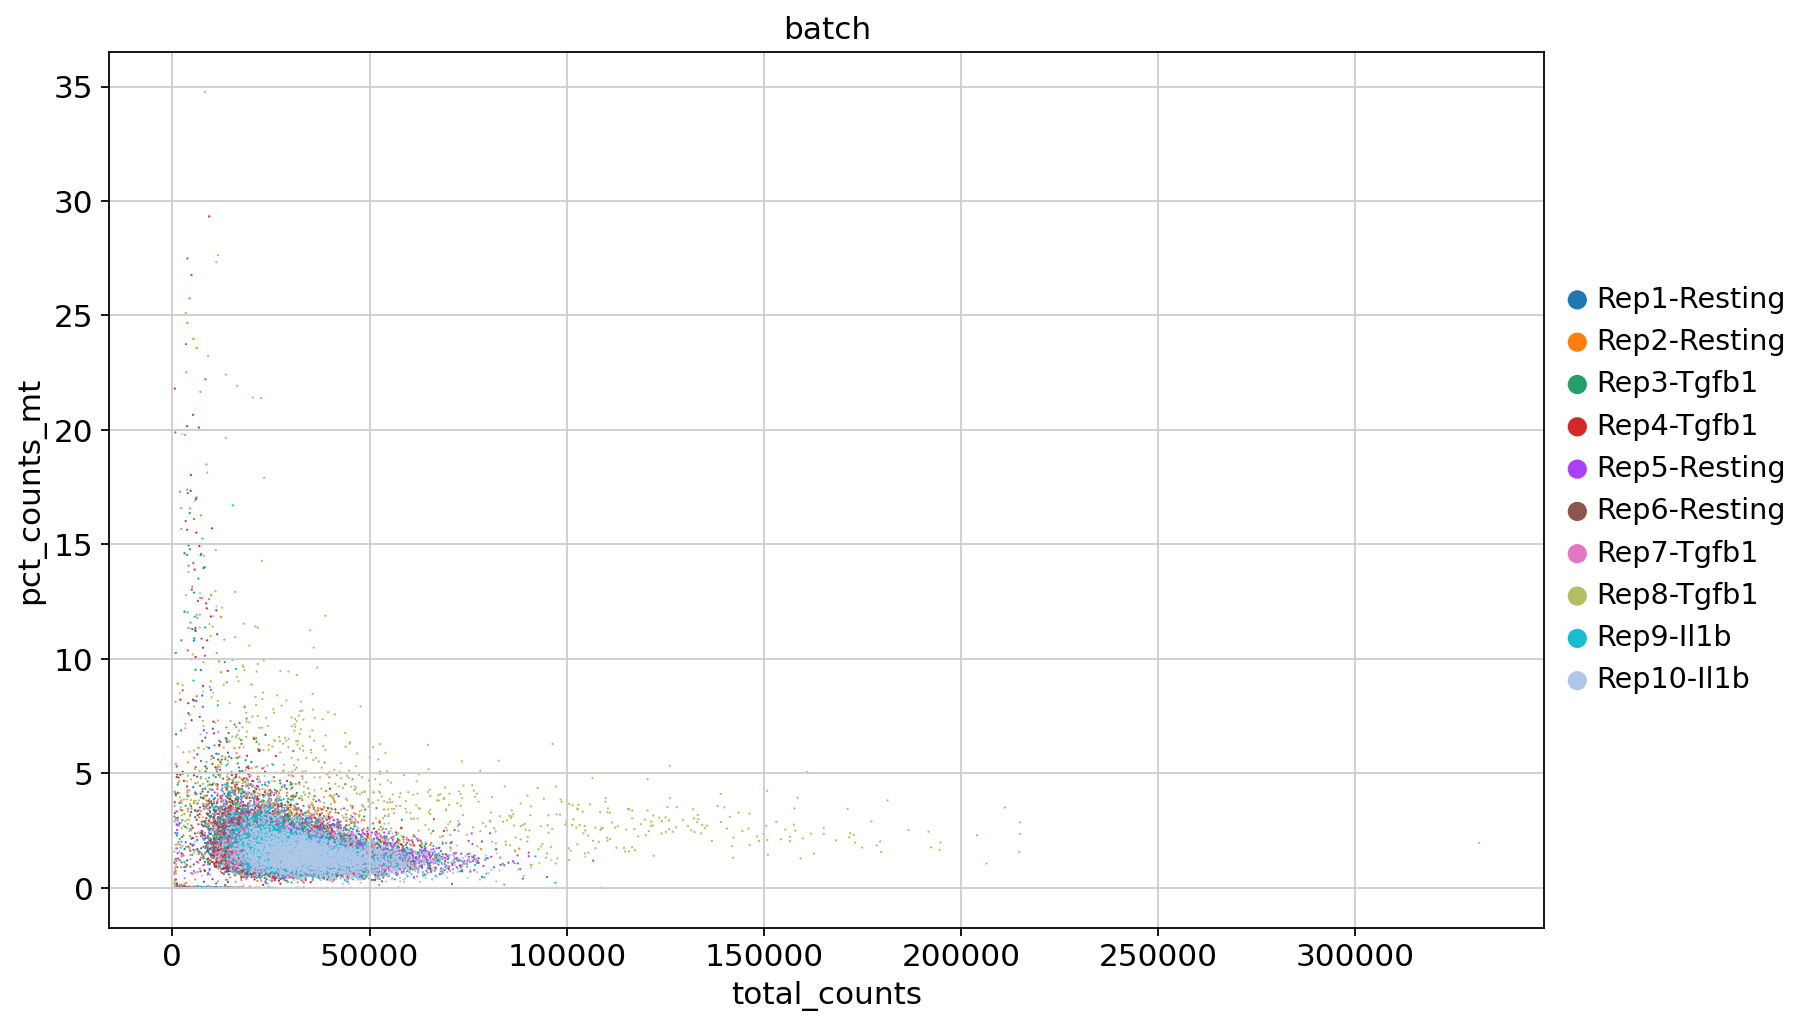

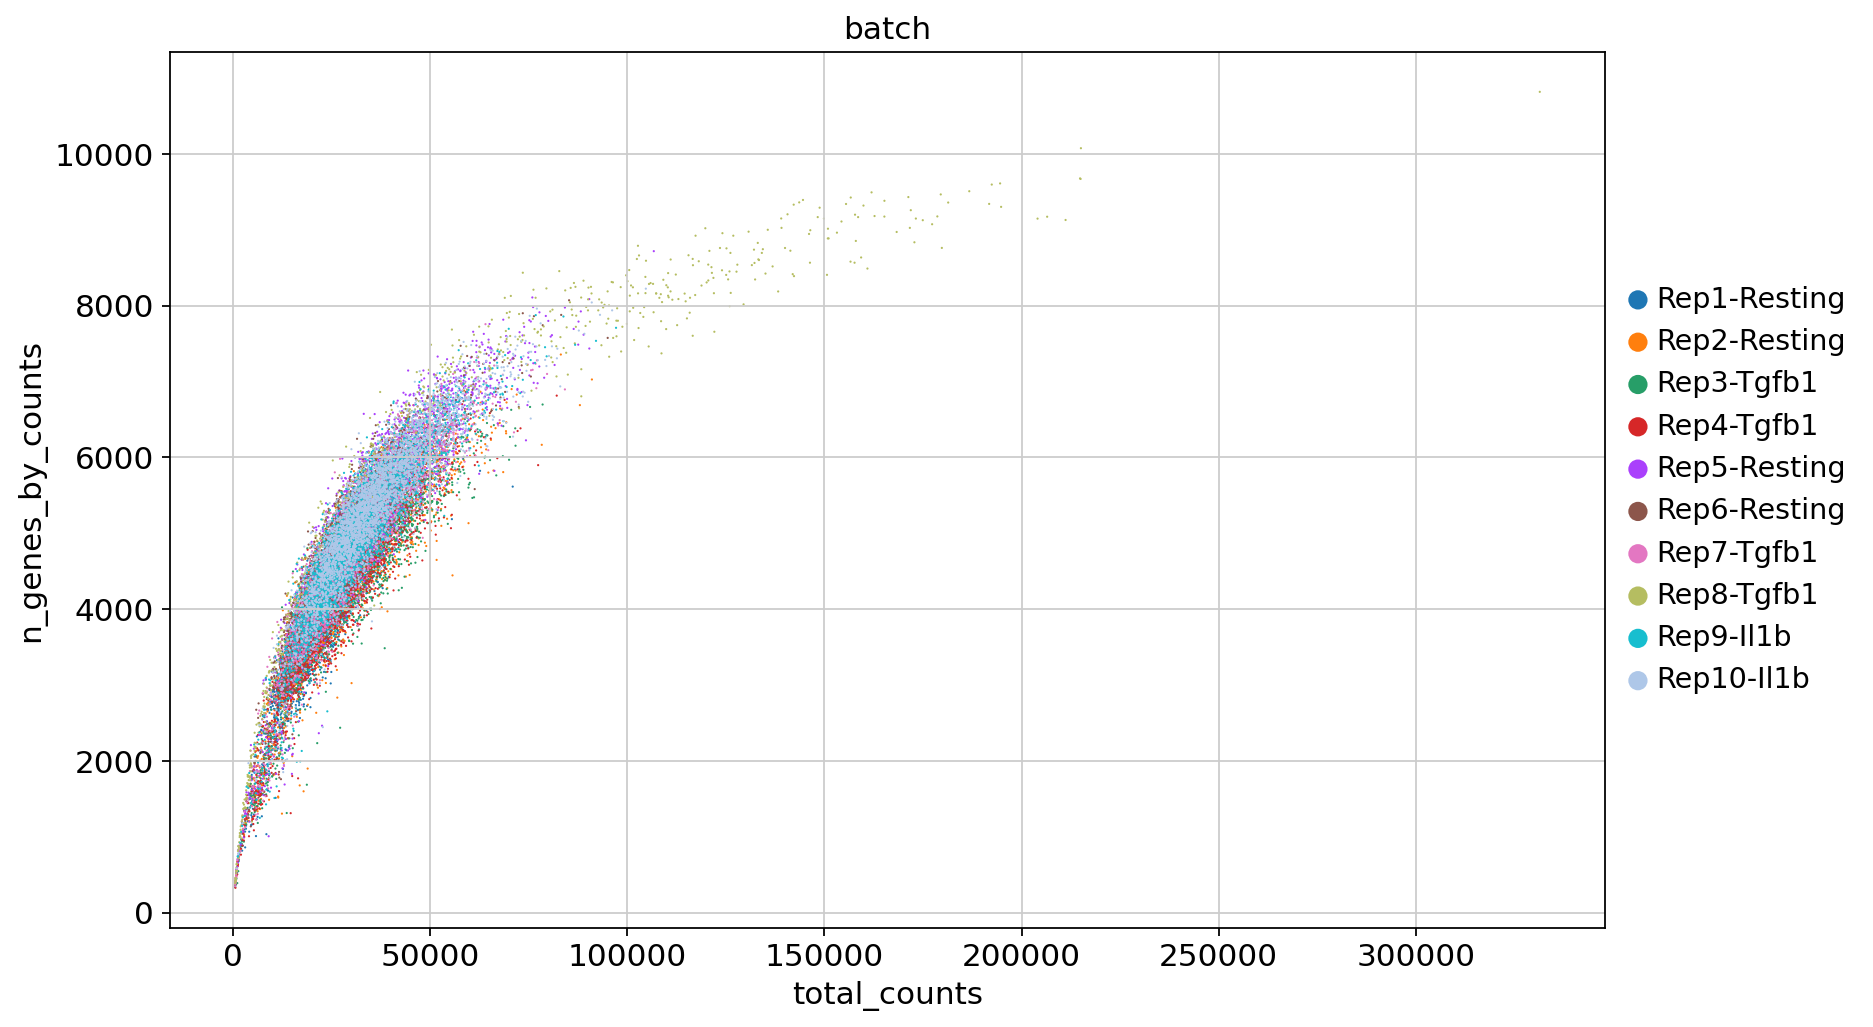

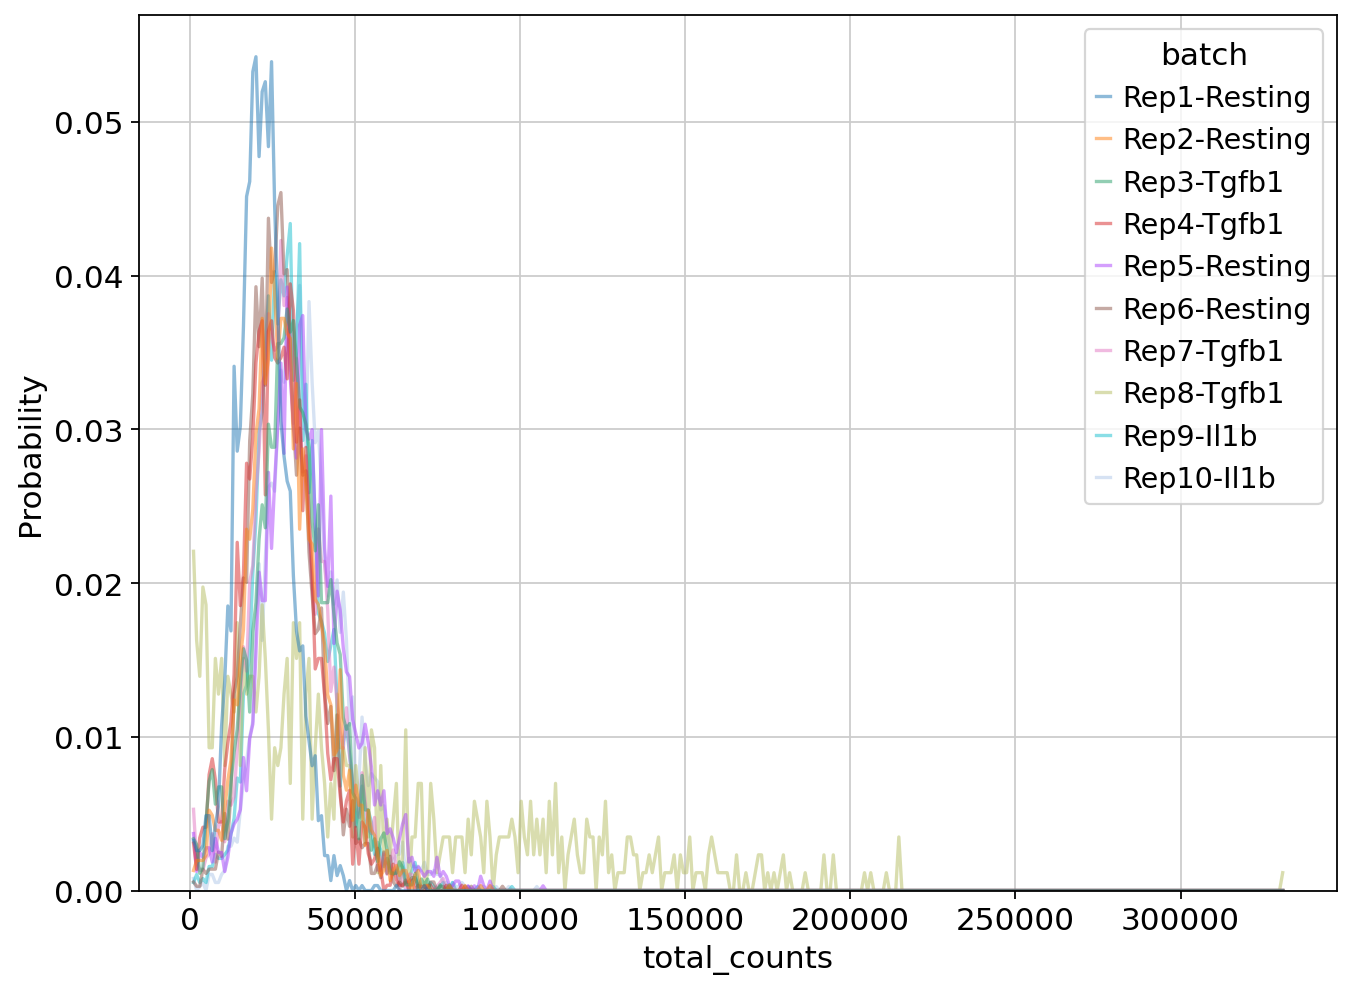

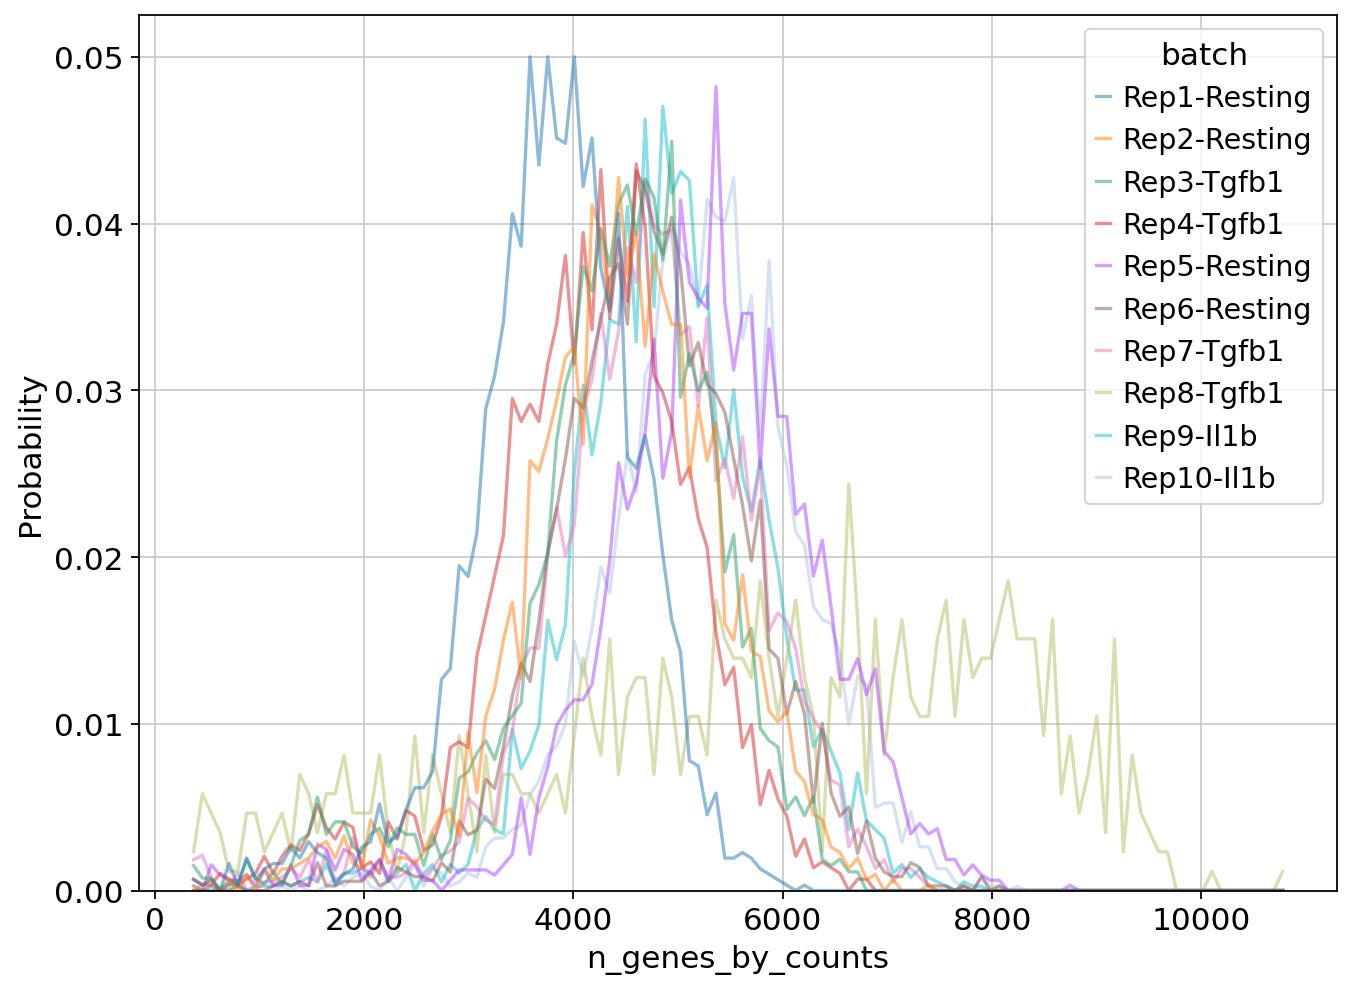

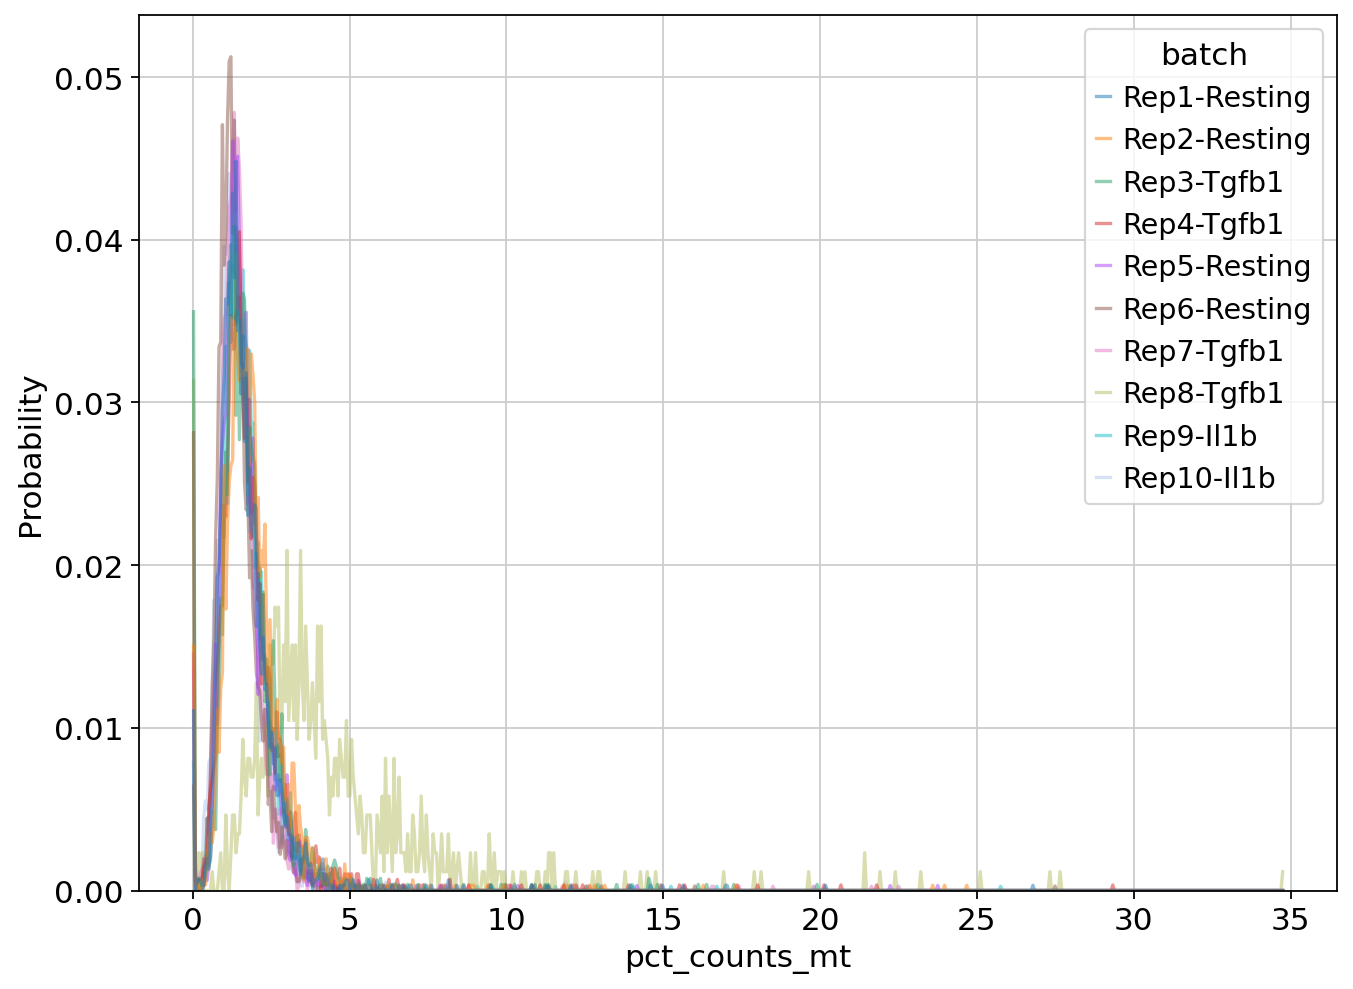

<Figure size 768x576 with 0 Axes>

In [19]:
#create_plots(adata, 'batch')
create_plots_and_save(adata, 'batch', 'preQC_fibroblasts')

In [20]:
c_targets = pd.Categorical( adata.obs.target.unique() ) 
c_targets

['Kat5', 'Kat8', 'non-targeting', 'Znhit1', 'Arid2', ..., 'Smarca4', 'Rnf40', 'Smad2', 'Chd4', 'Rest']
Length: 31
Categories (31, object): ['Arid2', 'Brd7', 'Brd9', 'Chd4', ..., 'Yeats4', 'Yy1', 'Znhit1', 'non-targeting']

In [21]:
adata = adata[adata.obs.pct_counts_mt < 6, :] # was 5 before
adata = adata[adata.obs.pct_counts_mt > 0.1, :] 
adata = adata[adata.obs.n_genes_by_counts > 1500, :]
sc.pp.filter_cells(adata, min_counts = 6000 ) 
sc.pp.filter_cells(adata, max_counts = 100000 ) 

/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


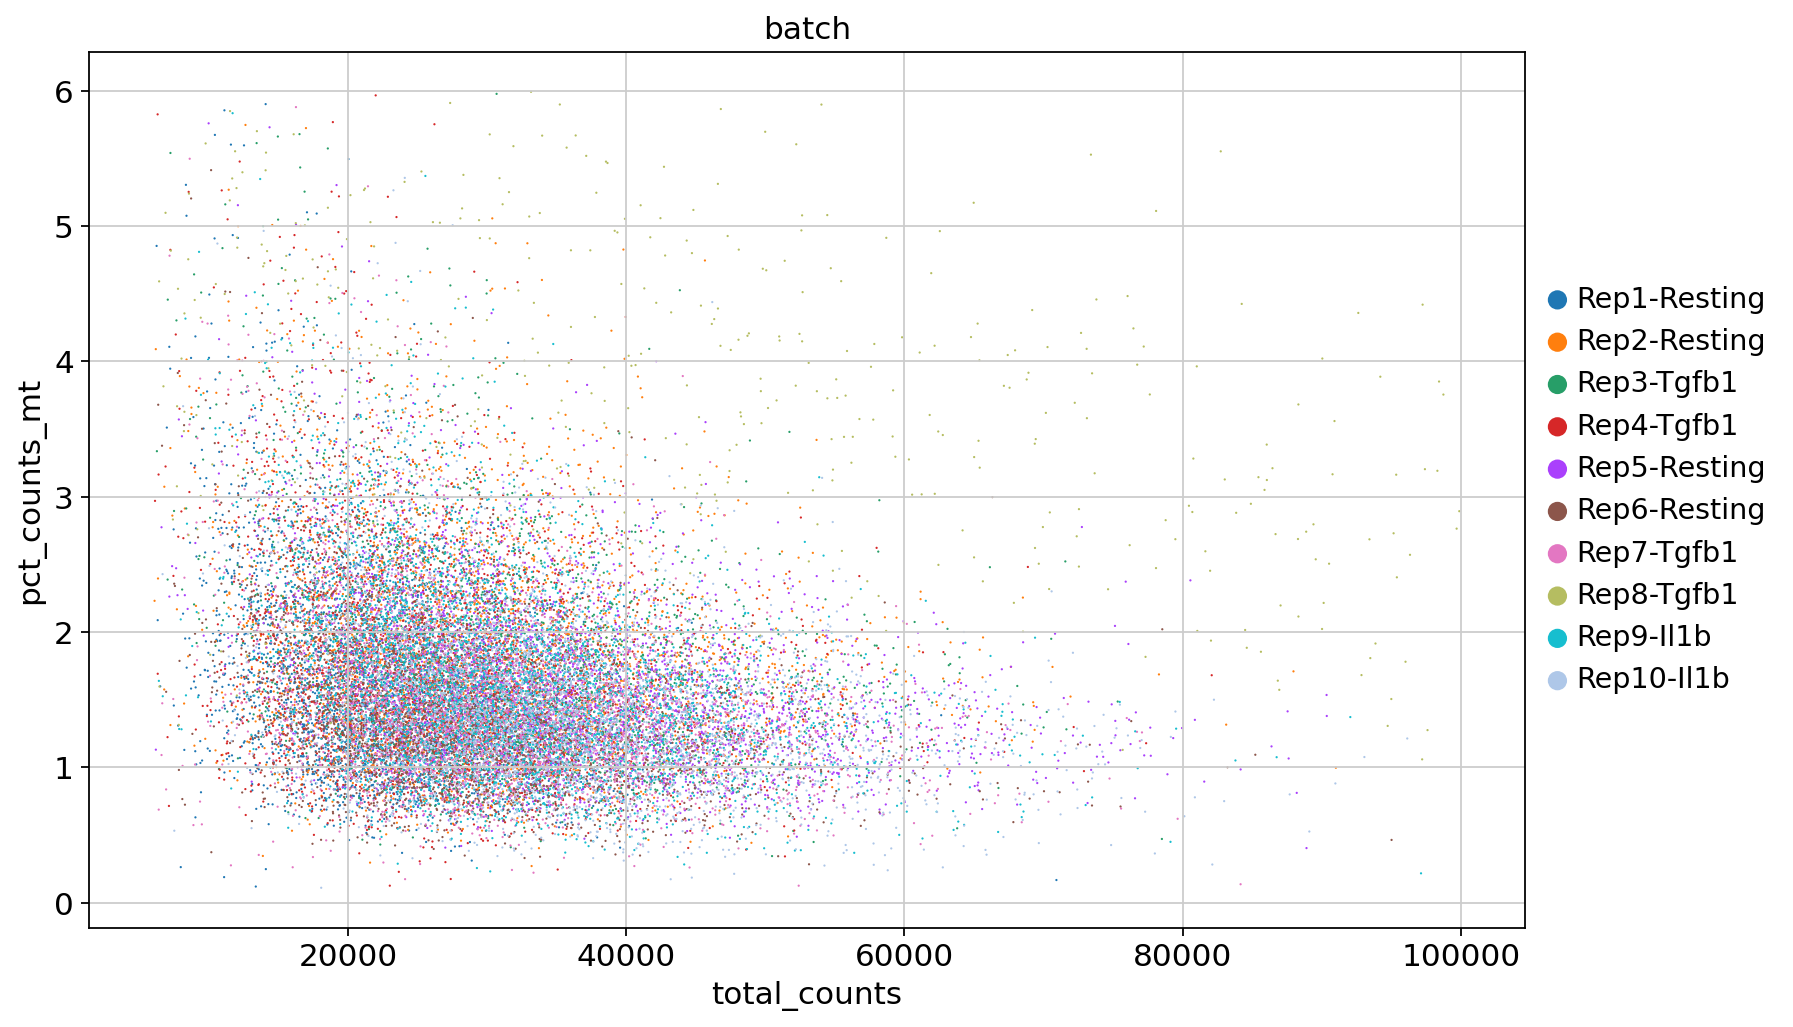

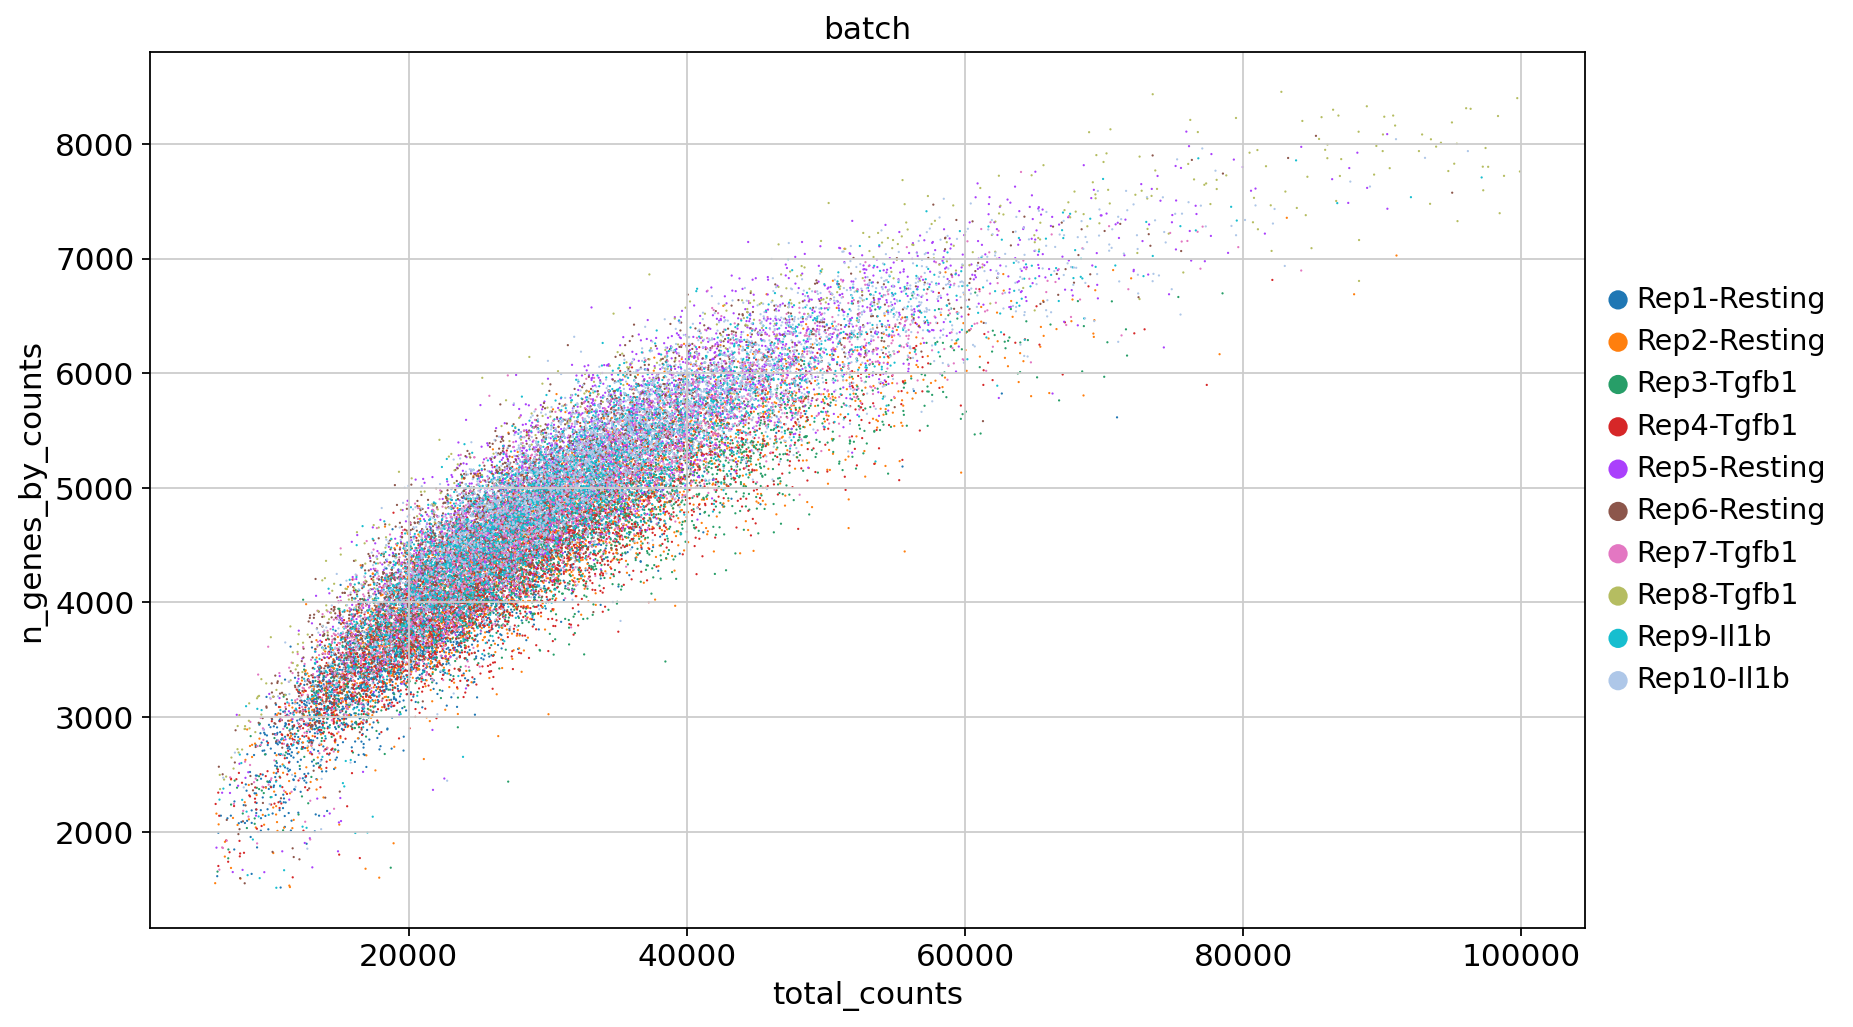

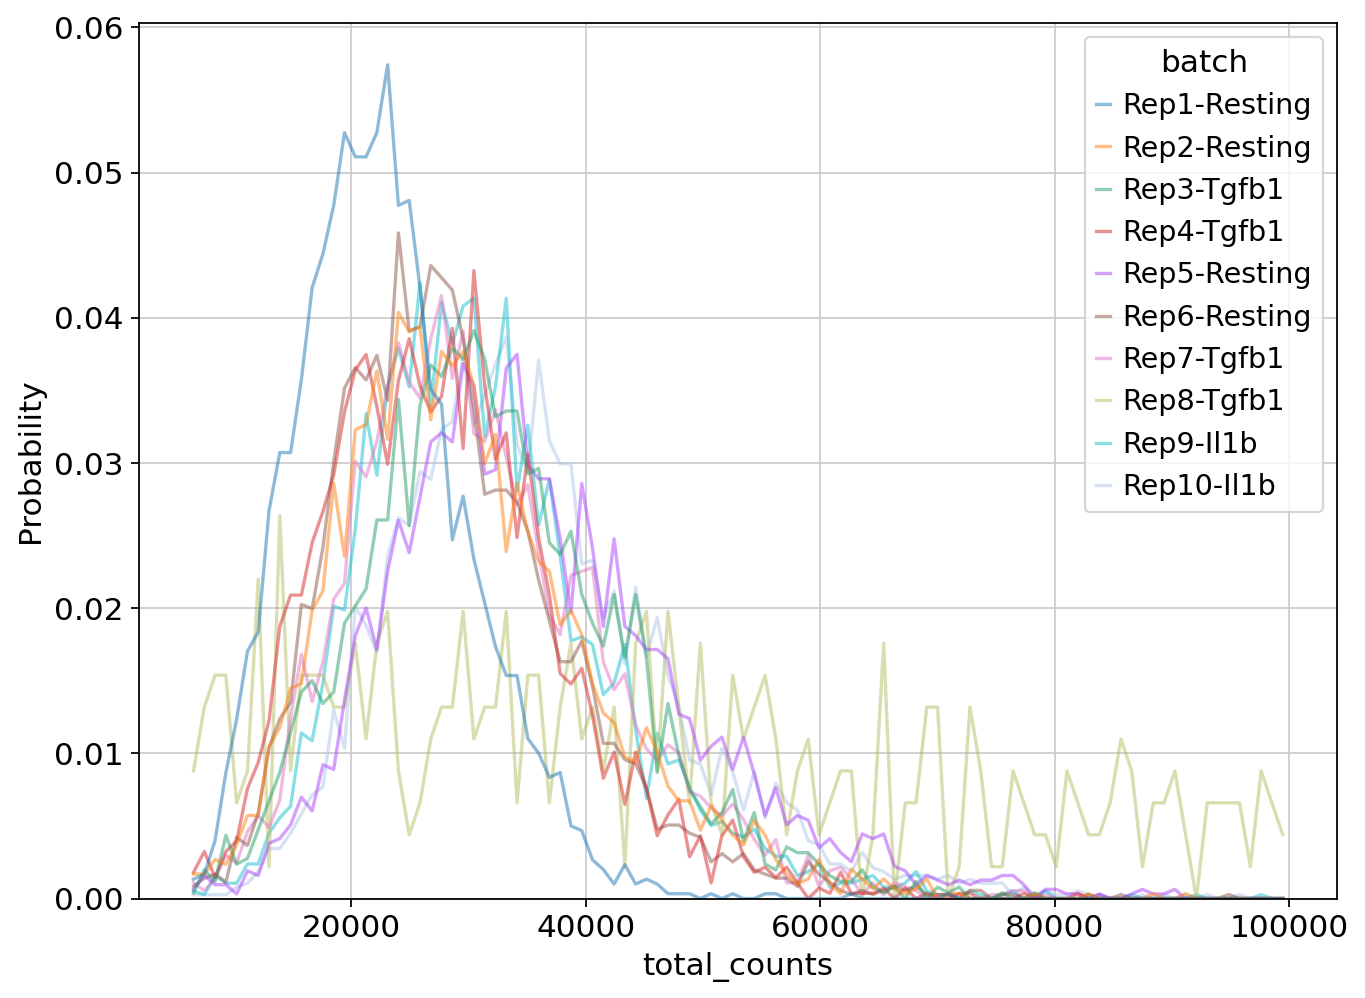

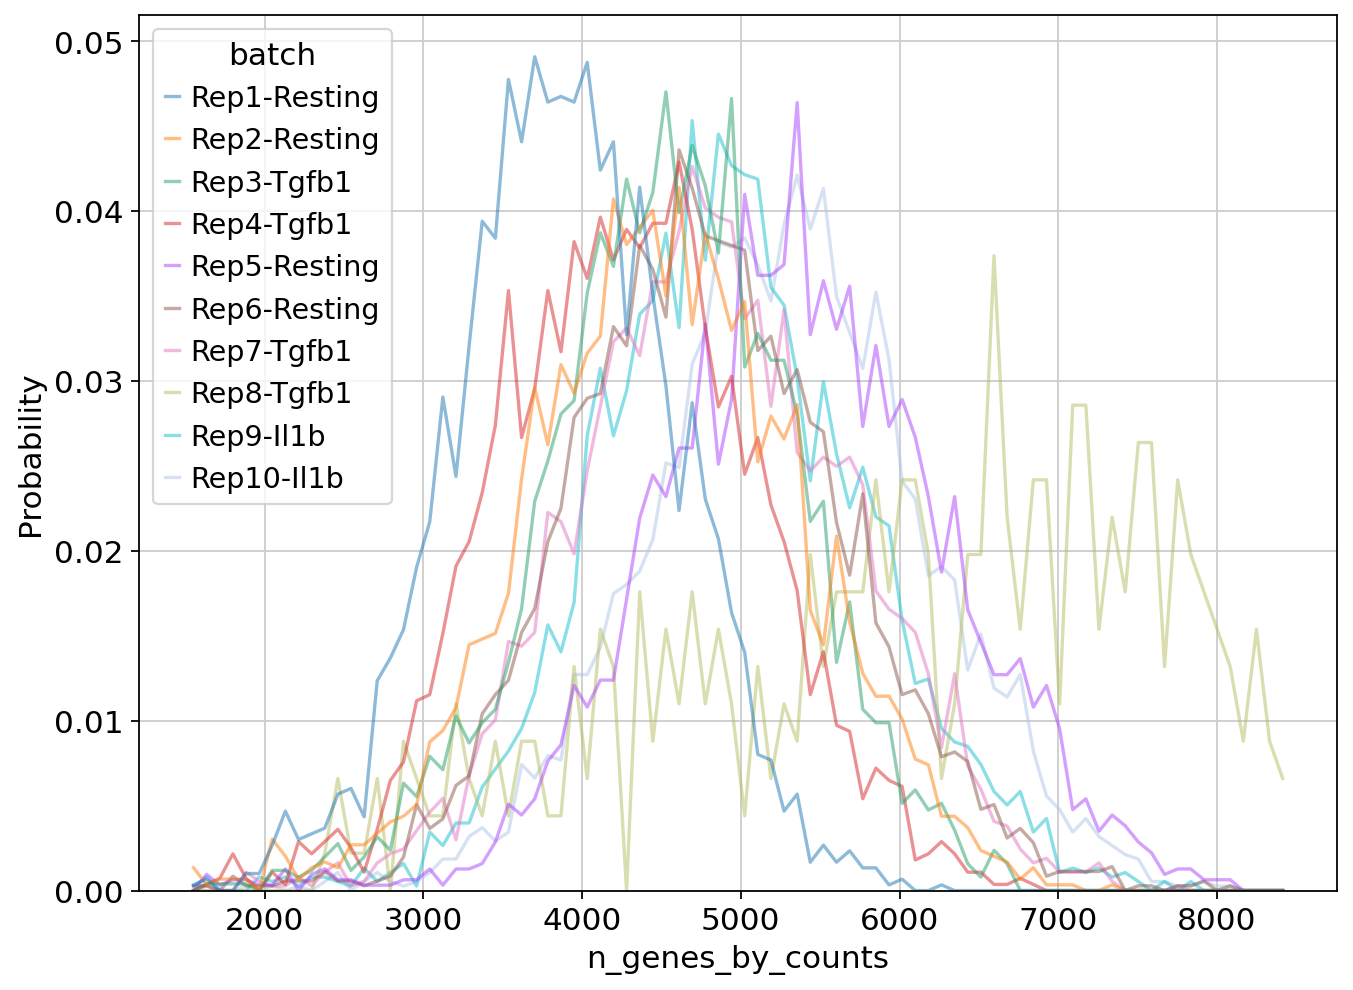

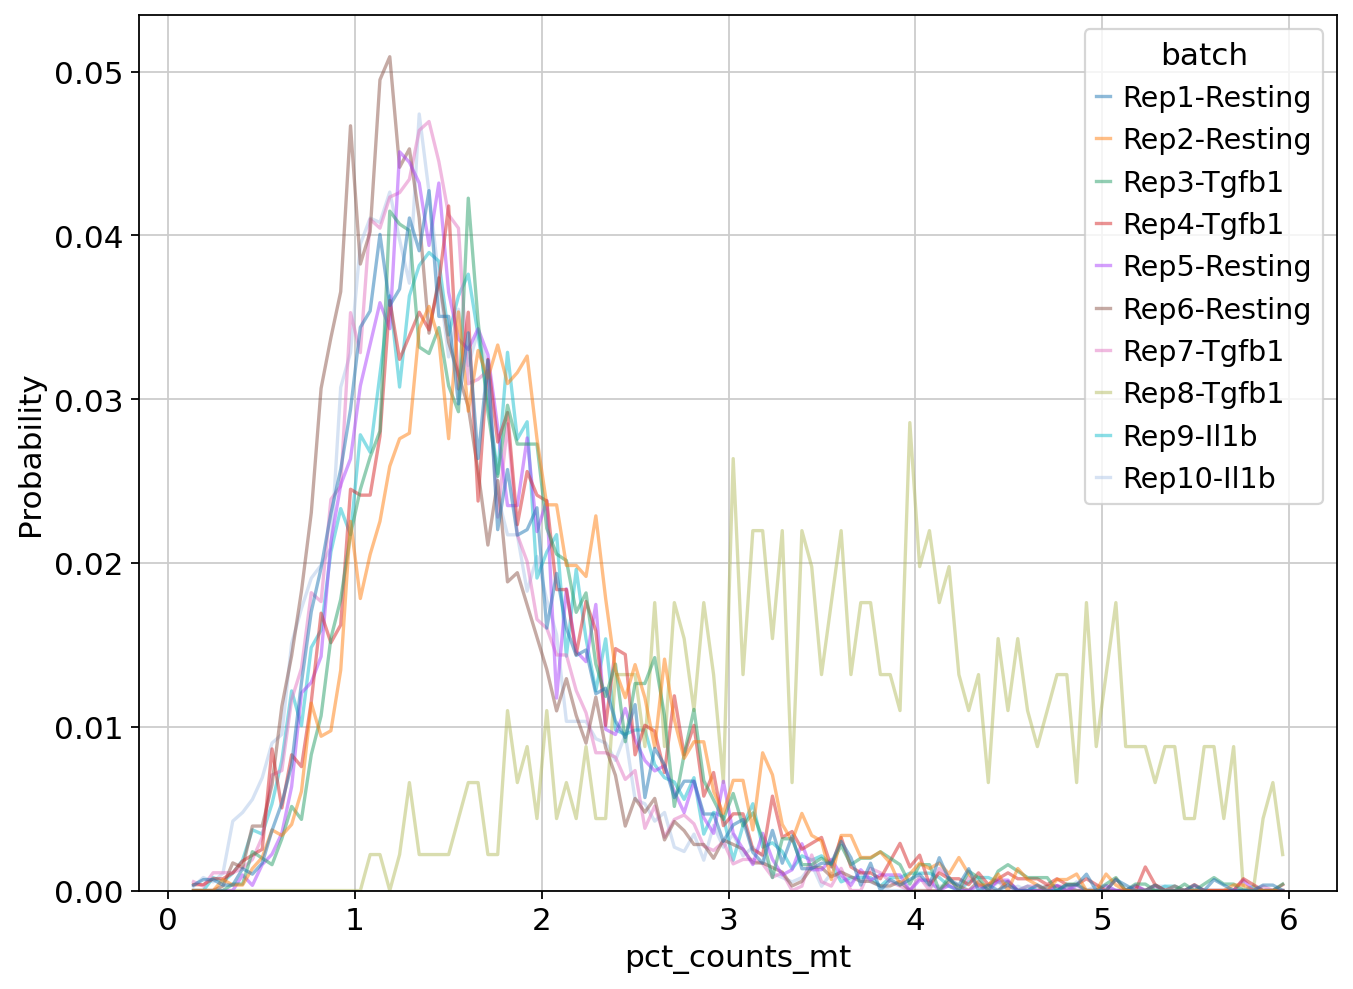

<Figure size 768x576 with 0 Axes>

In [22]:
#create_plots(adata, 'batch')
create_plots_and_save(adata, 'batch', 'postQC_fibroblasts')

In [23]:
DF = adata.to_df()
DF['target'] = adata.obs.target
DF['batch'] = adata.obs.batch
DF['condition'] = adata.obs.condition
to_keep_mat = DF.groupby(['condition','batch','target']).sum() # How many counts for each gene detected within target group??
tmp = DF.groupby(['condition','batch','target']).count() # How many cells in each target group??
ind_kp = tmp.sum(axis=1) != 0

to_keep_mat = to_keep_mat[ind_kp]
tmp = tmp[ind_kp]
to_keep_mat = to_keep_mat.div(tmp.iloc[:,1], axis='rows') # Number of counts per target pop / Number of cells per target pop

del tmp, DF
to_keep_mat

/tmp/ipykernel_3459/95524335.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  to_keep_mat = DF.groupby(['condition','batch','target']).sum() # How many counts for each gene detected within target group??
/tmp/ipykernel_3459/95524335.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = DF.groupby(['condition','batch','target']).count() # How many cells in each target group??


MGI_symbol                              Xkr4  Gm1992   Gm19938  Gm37381  Rp1  \
condition batch      target                                                    
Il1b      Rep9-Il1b  Arid2          0.000000     0.0  0.000000      0.0  0.0   
                     Brd7           0.018750     0.0  0.006250      0.0  0.0   
                     Brd9           0.000000     0.0  0.017699      0.0  0.0   
                     Chd4           0.000000     0.0  0.000000      0.0  0.0   
                     Dmap1          0.000000     0.0  0.000000      0.0  0.0   
...                                      ...     ...       ...      ...  ...   
Tgfb1     Rep8-Tgfb1 Wdr82          0.000000     0.0  0.000000      0.0  0.0   
                     Yeats4         0.000000     0.0  0.000000      0.0  0.0   
                     Yy1            0.100000     0.0  0.200000      0.0  0.0   
                     Znhit1         0.045455     0.0  0.045455      0.0  0.0   
                     non-targeting  0.058824     0.0  0.117647      0.0  0.0   

MGI_symbol                          Sox17  Gm37587  Gm37323    Mrpl15  \
condition batch      target                                             
Il1b      Rep9-Il1b  Arid2            0.0      0.0  0.00000  2.868687   
                     Brd7             0.0      0.0  0.00625  2.750000   
                     Brd9             0.0      0.0  0.00000  2.902655   
                     Chd4             0.0      0.0  0.00000  2.425000   
                     Dmap1            0.0      0.0  0.00000  1.736264   
...                                   ...      ...      ...       ...   
Tgfb1     Rep8-Tgfb1 Wdr82            0.0      0.0  0.00000  0.333333   
                     Yeats4           0.0      0.0  0.00000  3.600000   
                     Yy1              0.0      0.0  0.00000  5.200000   
                     Znhit1           0.0      0.0  0.00000  3.045455   
                     non-targeting    0.0      0.0  0.00000  4.176471   

MGI_symbol                            Lypla1  ...  Ac163611.2  Ac140365.1  \
condition batch      target                   ...                           
Il1b      Rep9-Il1b  Arid2          0.686869  ...         0.0         0.0   
                     Brd7           0.693750  ...         0.0         0.0   
                     Brd9           0.778761  ...         0.0         0.0   
                     Chd4           0.375000  ...         0.0         0.0   
                     Dmap1          0.527473  ...         0.0         0.0   
...                                      ...  ...         ...         ...   
Tgfb1     Rep8-Tgfb1 Wdr82          1.333333  ...         0.0         0.0   
                     Yeats4         3.200000  ...         0.0         0.0   
                     Yy1            1.900000  ...         0.0         0.0   
                     Znhit1         1.818182  ...         0.0         0.0   
                     non-targeting  1.529412  ...         0.0         0.0   

MGI_symbol                          Ac124606.2  Ac124606.1  Ac133095.2  \
condition batch      target                                              
Il1b      Rep9-Il1b  Arid2                 0.0         0.0         0.0   
                     Brd7                  0.0         0.0         0.0   
                     Brd9                  0.0         0.0         0.0   
                     Chd4                  0.0         0.0         0.0   
                     Dmap1                 0.0         0.0         0.0   
...                                        ...         ...         ...   
Tgfb1     Rep8-Tgfb1 Wdr82                 0.0         0.0         0.0   
                     Yeats4                0.0         0.0         0.0   
                     Yy1                   0.0         0.0         0.0   
                     Znhit1                0.0         0.0         0.0   
                     non-targeting         0.0         0.0         0.0   

MGI_symbol                          Ac133095

In [24]:
def filtering_genes_retained(to_keep_mat, adata, XX):
    to_keep_mat = (to_keep_mat >= XX) # Mark cases whereby the average count per population is greater than XX.
    to_keep_mat = to_keep_mat.astype(int)
    to_keep_mat.reset_index(inplace=True)
    tmp1 = to_keep_mat.drop(columns=['batch']).groupby(['target','condition']).sum().astype(int)
    tmp2 = to_keep_mat.groupby(['target','condition']).count().drop(columns=['batch']).astype(int) # Mark genes that have this property for every batch
    to_keep_mat2 = tmp1 == tmp2 # Mark genes that have this property for every batch
    to_keep = to_keep_mat2.any(axis=0) # Mark genes that have this property for some target
    to_keep = to_keep[to_keep].index
    del to_keep_mat2, to_keep_mat, tmp1, tmp2
    return to_keep

In [25]:
adata_tmp = adata.copy()
adata_tmp.obs = adata_tmp.obs[['target','condition','batch']]
n_pts = 21
x = np.linspace(0.1, 10.1, n_pts)
y = np.zeros(n_pts)
for ii in range(n_pts):
    y[ii] = len(filtering_genes_retained(to_keep_mat, adata_tmp, x[ii]))
del adata_tmp

/tmp/ipykernel_3459/2987097024.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp1 = to_keep_mat.drop(columns=['batch']).groupby(['target','condition']).sum().astype(int)
/tmp/ipykernel_3459/2987097024.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp2 = to_keep_mat.groupby(['target','condition']).count().drop(columns=['batch']).astype(int) # Mark genes that have this property for every batch
/tmp/ipykernel_3459/2987097024.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obse

<Axes: >

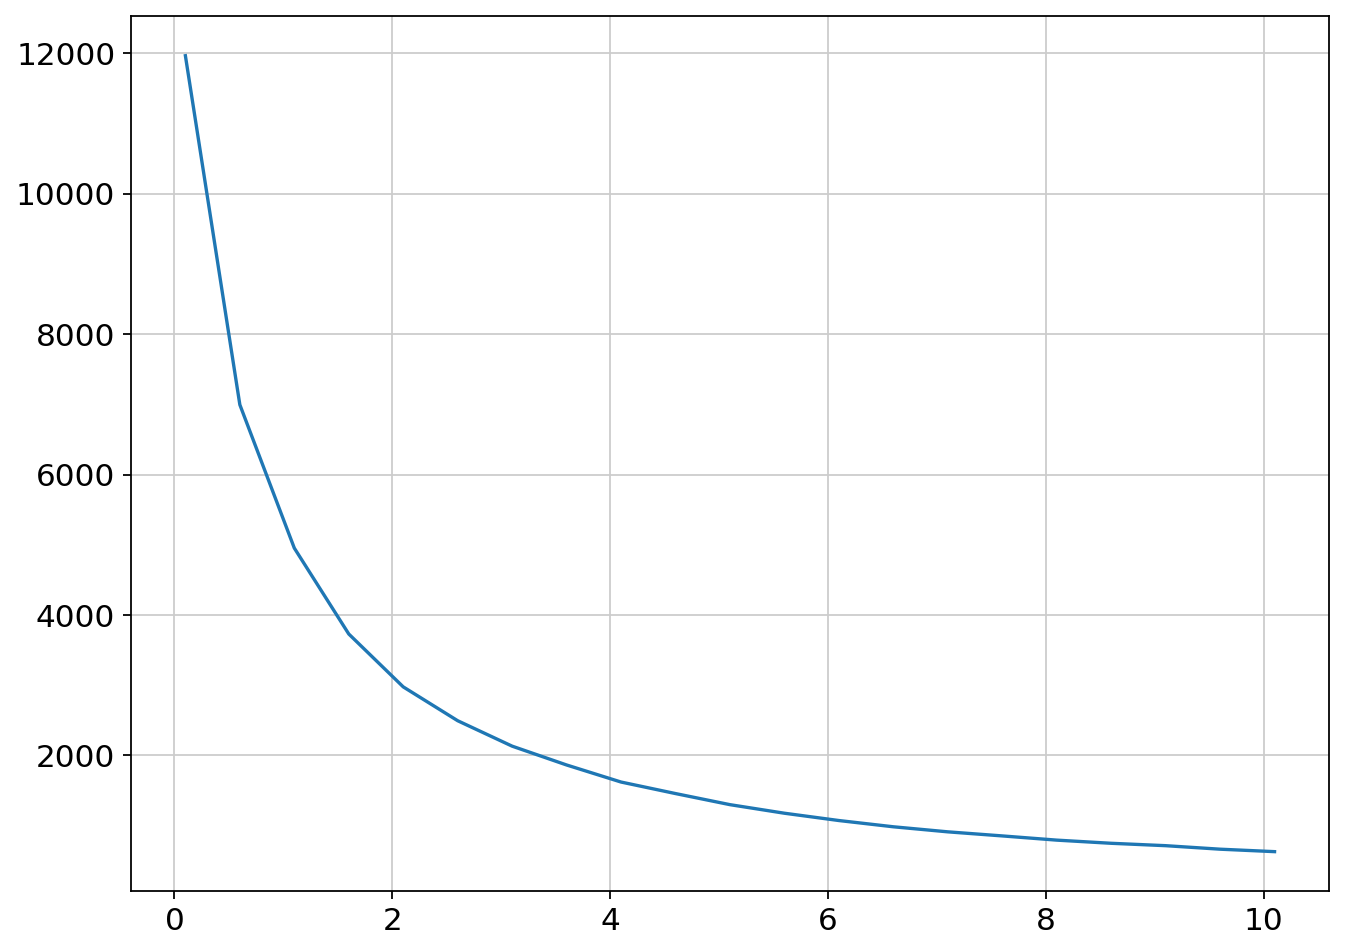

In [26]:
sns.lineplot(x = x, y = y)

In [27]:
to_keep = filtering_genes_retained(to_keep_mat, adata, 1)
print(to_keep)

Index(['Mrpl15', 'Tcea1', 'Atp6v1h', 'Rb1cc1', 'Pcmtd1', 'Rrs1', 'Snhg6',
       'Cops5', 'Cspp1', 'Arfgef1',
       ...
       'Mt-nd4l', 'Mt-nd4', 'Mt-nd5', 'Mt-nd6', 'Mt-cytb', 'Caaa01118383.1',
       'Vamp7', 'Ac149090.1', 'Gfp', 'Bfp'],
      dtype='object', name='MGI_symbol', length=5278)


/tmp/ipykernel_3459/2987097024.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp1 = to_keep_mat.drop(columns=['batch']).groupby(['target','condition']).sum().astype(int)
/tmp/ipykernel_3459/2987097024.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp2 = to_keep_mat.groupby(['target','condition']).count().drop(columns=['batch']).astype(int) # Mark genes that have this property for every batch


In [28]:
to_keep = pd.Categorical(to_keep)
to_keep = pd.api.types.union_categoricals([ c_targets, to_keep, pd.Categorical(['non-targeting']) ]).unique() # Make sure CRISPR targets are retained.
adata = adata[adata.obs.target.isin( to_keep )]
adata = adata[:, adata.var.index.isin(to_keep)]
print(to_keep)
del to_keep

['Kat5', 'Kat8', 'non-targeting', 'Znhit1', 'Arid2', ..., 'Caaa01118383.1', 'Vamp7', 'Ac149090.1', 'Gfp', 'Bfp']
Length: 5289
Categories (5289, object): ['Arid2', 'Brd7', 'Brd9', 'Chd4', ..., 'Zyg11b', 'Zyx', 'Zzef1', 'Zzz3']


In [29]:
sc.pp.normalize_total(adata, target_sum=10**4)
sc.pp.log1p(adata)

/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [30]:
adata

AnnData object with n_obs × n_vars = 29663 × 5288
    obs: 'sgRNA', 'misc:umi_count', 'condition', 'batch', 'target', 'is_nt', 'moi', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'rep', 'n_counts'
    uns: 'batch_colors', 'log1p'

In [31]:
adata.write_h5ad('../Rd13_Data_post_filtering_gene_sel-reseq.h5ad.gzip', compression='gzip')